# Semantic segmentation

Kohlmann András, Continental, andras.kohlmann@continental-corporation.com, 2018-10-09

Some inspiration is from https://github.com/0bserver07/Keras-SegNet-Basic

![title](img/semseg.png)

## Hardware check

In [88]:
import tensorflow as tf
import cv2
import numpy as np
import json
from keras.backend.tensorflow_backend import set_session
from tensorflow.python.client import device_lib
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))
# Device check
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17140252228678811583
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1471299584
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11661275118372875657
physical_device_desc: "device: 0, name: Quadro M1000M, pci bus id: 0000:01:00.0, compute capability: 5.0"
]


## First, the data

### Cityscapes dataset

https://www.cityscapes-dataset.com/dataset-overview/


In [89]:
import matplotlib.pyplot as plt
import glob, os
from keras.utils.np_utils import to_categorical
import numpy as np

### Loading files

In [90]:
train_images = os.path.join( './CityScapes_data' , "leftImg8bit"   , "train" , "*" , "*_leftImg8bit.png" )
train_images = glob.glob( train_images )
train_images.sort()

train_labels = os.path.join( './CityScapes_data' , "gtFine"   , "train" , "*" , "*_labelIds.png" )
train_labels = glob.glob( train_labels )
train_labels.sort()

assert len(train_images) == len(train_labels)

In [91]:
val_images = os.path.join( './CityScapes_data' , "leftImg8bit"   , "val" , "*" , "*_leftImg8bit.png" )
val_images = glob.glob( val_images )
val_images.sort()

val_labels = os.path.join( './CityScapes_data' , "gtFine"   , "val" , "*" , "*_labelIds.png" )
val_labels = glob.glob( val_labels )
val_labels.sort()

assert len(val_images) == len(val_labels)

In [92]:
print('{0} train data, {1} validation data'.format(len(train_images), len(val_images)))

2975 train data, 500 validation data


### Creating data generator for training

In [93]:
import imageio

In [94]:
from keras.applications import imagenet_utils
def preprocess_input(x):
    return imagenet_utils.preprocess_input(x, mode='tf')

In [95]:
def data_generator(images, labels, batch_size=32, dim=(1024, 2048), n_classes=34, shuffle=True):
    # Initialization
    data_size = len(images)
    nbatches = data_size // batch_size
    list_IDs = np.arange(data_size)
    indices = list_IDs
    
    # Data generation
    while True:
        if shuffle == True:
            np.random.shuffle(indices)
        for index in range(nbatches):
            batch_indices = indices[index*batch_size:(index+1)*batch_size]

            X = np.empty((batch_size, *dim, 3))
            y_semseg = np.empty((batch_size, *dim), dtype=int)

            for i, ID in enumerate(batch_indices):
                image = cv2.resize(np.array(imageio.imread(images[ID]), dtype=np.uint8), dim[1::-1])
                label = cv2.resize(imageio.imread(labels[ID]), dim[1::-1], interpolation=cv2.INTER_NEAREST)
                X[i,] = image
                y_semseg[i] = label
            yield (preprocess_input(X), to_categorical(y_semseg, num_classes=n_classes))
        

In [96]:
batch_size = 2
data_shape = (160,320)
classes = 34

In [97]:
train_generator = data_generator(train_images, train_labels, batch_size=batch_size, dim=data_shape, n_classes=classes)
val_generator = data_generator(val_images, val_labels, batch_size=batch_size, dim=data_shape, n_classes=classes)

### Visualizing data

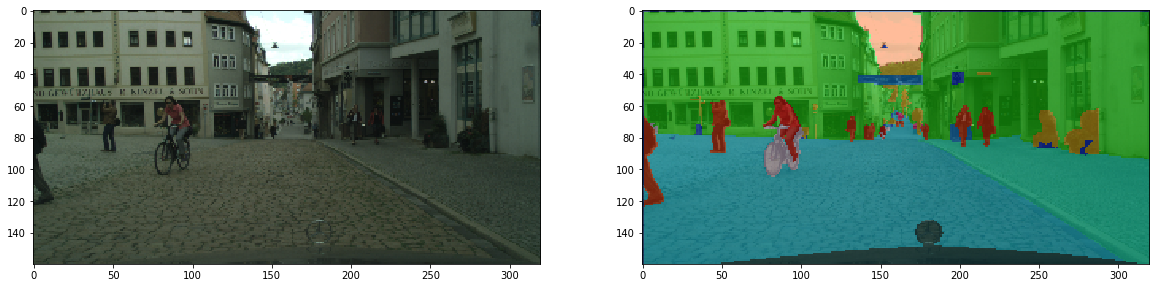

In [98]:
i = 0
image, label = next(train_generator)
image = image[i]
label = np.argmax(label[i], axis=-1)

fig=plt.figure(figsize=(20, 10))

cm = plt.get_cmap('gist_ncar')

fig.add_subplot(1, 2, 1)
plt.imshow(image * .5 + .5)
fig.add_subplot(1, 2, 2)
plt.imshow((image * .5 + .5) * .6 + cm(label/34.)[...,:3] * .4)
plt.show()

## Defining the neural network

### Inspiration:
http://mi.eng.cam.ac.uk/projects/segnet/

https://arxiv.org/abs/1505.07293

![title](img/Segnet--.png)

In [99]:
import keras.models as models
from keras.models import Model
from keras.layers import Input
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape, Permute
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization

In [100]:
from keras import backend as K

In [101]:
def create_encoding_layers(input_layer):
    kernel = 3
    filter_size = 64
    pool_size = 2
    
    x = Conv2D(filter_size, kernel, padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(pool_size, pool_size))(x)

    x = Conv2D(128, kernel, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(pool_size, pool_size))(x)

    x = Conv2D(256, kernel, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(pool_size, pool_size))(x)

    x = Conv2D(512, kernel, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [102]:
def create_decoding_layers(input_layer):
    kernel = 3
    filter_size = 64
    pool_size = 2

    x = Conv2D(512, kernel, padding='same')(input_layer)
    x = BatchNormalization()(x)

    x = UpSampling2D(size=(pool_size,pool_size))(x)
    x = Conv2D(256, kernel, padding='same')(x)
    x = BatchNormalization()(x)

    x = UpSampling2D(size=(pool_size,pool_size))(x)
    x = Conv2D(128, kernel, padding='same')(x)
    x = BatchNormalization()(x)

    x = UpSampling2D(size=(pool_size,pool_size))(x)
    x = Conv2D(filter_size, kernel, padding='same')(x)
    x = BatchNormalization()(x)
    
    return x

In [103]:
input_layer = Input((*data_shape, 3))

In [104]:
encoded_layer = create_encoding_layers(input_layer)
decoded_layer = create_decoding_layers(encoded_layer)

In [105]:
final_layer = Conv2D(classes, 1, padding='same')(decoded_layer)
final_layer = Activation('softmax')(final_layer)

In [106]:
semseg_model = Model(inputs=input_layer, outputs=final_layer)

## Training the network

In [107]:
semseg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [108]:
semseg_model.fit_generator(generator=train_generator,
                          steps_per_epoch=len(train_images) // batch_size,
                           epochs=1, validation_data=val_generator,
                           validation_steps=len(val_images) // batch_size)

Epoch 1/1
1487/1487 [==============================] - 593s 399ms/step - loss: 1.0273 - acc: 0.7144 - val_loss: 1.6215 - val_acc: 0.5989


In [22]:
semseg_model.save_weights('trained_model.h5')

## Inference

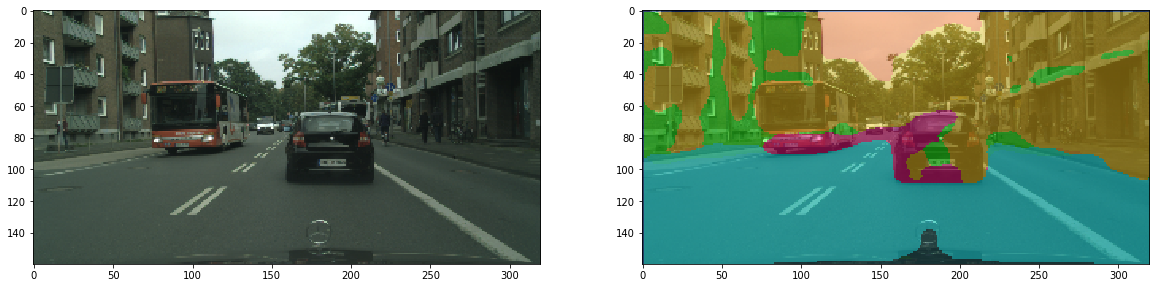

In [110]:
i = 0
image, label = next(val_generator)
#image = image[i]
#label = np.argmax(label[i], axis=-1)

pred = semseg_model.predict(image)
pred = np.argmax(pred[0], axis=-1)
fig=plt.figure(figsize=(20, 10))

cm = plt.get_cmap('gist_ncar')

fig.add_subplot(1, 2, 1)
plt.imshow(image[0] * .5 + .5)
fig.add_subplot(1, 2, 2)
plt.imshow((image[0] * .5 + .5) * .6 + cm(pred/34.)[...,:3] * .4)
plt.show()

## Model advancements

![title](img/Segnet--_residual.png)

In [24]:
from keras.layers import Concatenate

In [25]:
def create_encoding_layers_residual(input_layer):
    kernel = 3
    filter_size = 64
    pool_size = 2
    residual_connections = []
    
    x = Conv2D(filter_size, kernel, padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(pool_size, pool_size))(x)
    residual_connections.append(x)

    x = Conv2D(128, kernel, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(pool_size, pool_size))(x)
    residual_connections.append(x)

    x = Conv2D(256, kernel, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(pool_size, pool_size))(x)
    residual_connections.append(x)

    x = Conv2D(512, kernel, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x, residual_connections

In [26]:
def create_decoding_layers_residual(input_layer, residual_connections):
    kernel = 3
    filter_size = 64
    pool_size = 2

    x = Conv2D(512, kernel, padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = Concatenate()([x, residual_connections[2]])

    x = UpSampling2D(size=(pool_size,pool_size))(x)
    x = Conv2D(256, kernel, padding='same')(x)
    x = BatchNormalization()(x)
    x = Concatenate()([x, residual_connections[1]])

    x = UpSampling2D(size=(pool_size,pool_size))(x)
    x = Conv2D(128, kernel, padding='same')(x)
    x = BatchNormalization()(x)
    x = Concatenate()([x, residual_connections[0]])

    x = UpSampling2D(size=(pool_size,pool_size))(x)
    x = Conv2D(filter_size, kernel, padding='same')(x)
    x = BatchNormalization()(x)
    
    return x

In [57]:
input_layer = Input((*data_shape, 3))

In [58]:
encoded_layer, residual_conns = create_encoding_layers_residual(input_layer)
decoded_layer = create_decoding_layers_residual(encoded_layer, residual_conns)

In [59]:
final_layer = Conv2D(classes, 1, padding='same')(decoded_layer)
final_layer = Activation('softmax')(final_layer)

In [85]:
semseg_model_residual = Model(inputs=input_layer, outputs=final_layer)

# Training with residual connections

In [86]:
semseg_model_residual.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [87]:
semseg_model_residual.fit_generator(generator=train_generator,
                          steps_per_epoch=len(train_images) // batch_size,
                           epochs=1, validation_data=val_generator,
                           validation_steps=len(val_images) // batch_size)

Epoch 1/1
1487/1487 [==============================] - 637s 428ms/step - loss: 0.7768 - acc: 0.7803 - val_loss: 0.8785 - val_acc: 0.7605


In [33]:
semseg_model_residual.save_weights('trained_model_residual.h5')

# Inference

In [111]:
semseg_model_residual.load_weights('trained_model_residual_8.h5')

In [ ]:
i = 0
image, label = next(val_generator)

pred = semseg_model_residual.predict(image)
pred = np.argmax(pred[0], axis=-1)
fig=plt.figure(figsize=(20, 10))

cm = plt.get_cmap('gist_ncar')

fig.add_subplot(1, 2, 1)
plt.imshow(image[0] * .5 + .5)
fig.add_subplot(1, 2, 2)
plt.imshow((image[0] * .5 + .5) * .6 + cm(pred/34.)[...,:3] * .4)
plt.show()

# Performance metrics

![title](img/IoU.png)

In [36]:
from sklearn.metrics import classification_report
import progressbar
import itertools

In [37]:
labels = ['unlabeled','ego vehicle'  , 'rectification border', 'out of roi'  , 'static'  , 'dynamic' , 'ground'  , 'road'  ,'sidewalk'  ,'parking' , 'rail track', 'building' ,'wall' , 'fence', 'guard rail','bridge'  , 'tunnel' , 'pole' , 'polegroup' , 'traffic light' , 'traffic sign' ,'vegetation' , 'terrain' , 'sky'  , 'person'  , 'rider'  , 'car'   , 'truck'  , 'bus'       ,'caravan','trailer' ,'train','motorcycle','bicycle']

In [38]:
aggregated_intersection = np.zeros_like(labels, dtype=int)
aggregated_union = np.zeros_like(labels, dtype=int)
aggregated_support = np.zeros_like(labels, dtype=int)

progress = progressbar.ProgressBar(widgets=[progressbar.Bar('=', '[', ']'), ' ',
                                            progressbar.Percentage(), ' ',
                                            progressbar.ETA()])

for i in progress(range(len(val_images)//batch_size)):
    image_batch, label_batch = next(val_generator)
    pred_labels_batch = semseg_model_residual.predict_on_batch(image_batch)
    label_flat = np.argmax(label_batch, -1).flatten()
    pred_label_flat = np.argmax(pred_labels_batch, -1).flatten()
    for i, l in enumerate(labels):
        pred_mask = pred_label_flat == i
        label_mask = label_flat == i
        aggregated_intersection[i] += np.sum(np.logical_and(pred_mask, label_mask))
        aggregated_union[i] += np.sum(np.logical_or(pred_mask, label_mask))
        aggregated_support[i] += np.sum(label_mask)

[==========================================================] 100% Time: 0:01:48


In [39]:
for i, l in enumerate(labels):
#     print(l, aggregated_intersection[i]/aggregated_union[i], aggregated_support[i])
    print('{:20s} - {:3.2f}'.format(l, aggregated_intersection[i]/aggregated_union[i]))

unlabeled            - 0.00
ego vehicle          - 0.57
rectification border - 0.37
out of roi           - 0.33
static               - 0.02
dynamic              - 0.00
ground               - 0.00
road                 - 0.79
sidewalk             - 0.43
parking              - 0.03
rail track           - 0.00
building             - 0.63
wall                 - 0.02
fence                - 0.11
guard rail           - 0.00
bridge               - 0.04
tunnel               - nan
pole                 - 0.12
polegroup            - 0.00
traffic light        - 0.07
traffic sign         - 0.13
vegetation           - 0.68
terrain              - 0.33
sky                  - 0.80
person               - 0.24
rider                - 0.00
car                  - 0.50
truck                - 0.00
bus                  - 0.01
caravan              - 0.00
trailer              - 0.00
train                - 0.00
motorcycle           - 0.00
bicycle              - 0.19


C:\Users\uidk6234\anaconda3\envs\idp\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in long_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


## Further advancements

### Data

<ul>
<li>Reduce classes</li>
<li>Augmentation</li>
<li>More data</li>
</ul>

### Increasing complexity...

<ul>
<li>Pooling indices to UpSampling</li>
<li>UpSampling -> Deconvolution</li>
<li>Pooling -> Dilated Convolution</li>
<li>Deeper net</li>
<li>Higher resolution</li>
<li>Convolution blocks -> Inception/Xception/Resnet/... blocks</li>
</ul>

### ...will increase training time

<ul>
<li>Keras: multi_gpu_model</li>
<li>Distributed training...</li>
</ul>